Model Shellinga

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

Funkcja do inicjalizacji siatki

In [2]:
def initializeGrid(grid_size=50, density=0.75):
    num_cells = grid_size**2
    num_agents = int(num_cells * density)
    num_agents = (num_agents // 2) * 2
    agents = np.array([1] * (num_agents // 2) + [2] * (num_agents // 2) + [0] * (num_cells - num_agents))
    np.random.shuffle(agents)
    return agents.reshape(grid_size, grid_size)


Funkcja do pobrania informacji o sąsiadach(8 sąsiadów), oraz funkcja do pobrania tylko najbliższych sąsiadów(4 sądiadów)

In [3]:
def getNeighbors(grid, x, y):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
                neighbors.append(grid[nx, ny])
    return neighbors

In [4]:
def getDirectNeighbors(grid, x, y):
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
            neighbors.append(grid[nx, ny])
    return neighbors

Funkcja do sprawdzania zadowolenia agenta, na podstawie zadanej tolerancji

In [19]:
def isSatisfied(grid, x, y, tolerance):
    agent = grid[x, y]
    if agent == 0:
        return True
    neighbors = getDirectNeighbors(grid, x, y)
    if not neighbors:
        return False
    sameType = sum(1 for n in neighbors if n == agent)
    return sameType / len(neighbors) >= tolerance

Funkcja służąca do pobrania losowego agenta

In [20]:
def getRandomAgent(grid):
    allAgents = [(x, y) for x in range(grid.shape[0]) for y in range(grid.shape[1]) if grid[x, y] != 0]
    if not allAgents:
        return grid, False

    randomAgent = random.choice(allAgents)
    return randomAgent

Funkcja służąca do wykonania jednego kroku symulacji

In [65]:
def step(agent, grid, tolerance):
    satisfaction_numbers = [0, 0] #tych z 1, tych z 2
    x, y = agent
    if isSatisfied(grid, x, y, tolerance):
        return grid, False

    emptySpots = [(x, y) for x in range(grid.shape[0]) for y in range(grid.shape[1]) if grid[x, y] == 0]
    if emptySpots:
        newX, newY = random.choice(emptySpots)
        grid[newX, newY] = grid[x, y]
        grid[x, y] = 0
        return grid, True

    return grid, False


In [283]:
def total_number_of_satisfied_agents(grid, tolerance):
    satisfied_agents = 0
    unsatisfied_agents = 0

    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            if isSatisfied(grid, x, y, tolerance):
                satisfied_agents += 1
            else:
                unsatisfied_agents += 1
    return satisfied_agents, unsatisfied_agents

Funkcja główna służąca do symulacji

In [304]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import Polynomial

def runSchellingSimulation(grid_size=40, density=0.75, tolerance=0.3, plot_iterations=[10000], map=True, plot=True, listy=False): #dodalem map i plot zeby mozna bylo sobie ustawiac co chcemy rysowac
    grid = initializeGrid(grid_size, density)

    cmap = plt.cm.colors.ListedColormap(['white', 'green', 'blue'])

    iteration = 0

    #listy zadowolonych i niezadowolonych agentow
    satf_list = []
    unsatf_list = []

    while True:
        agent = getRandomAgent(grid)
        grid, has_moved = step(agent, grid, tolerance)

        iteration += 1

        if iteration in plot_iterations and map:
            plt.figure(figsize=(6, 6))
            plt.imshow(grid, cmap=cmap, vmin=0, vmax=2)
            plt.title(f'Iteration: {iteration}')
            plt.show(block=False)
            plt.pause(0.1)


        #dodalem zeby co 100 iteracji badalo cala plansze i liczylo ile jest zadowolonych i niezadowolonych
        if iteration % 100 == 0:
            satf, unsatf = total_number_of_satisfied_agents(grid, tolerance)
            satf_list.append(satf)
            unsatf_list.append(unsatf)

        #tutaj zmienilem po prostu -1 zeby bralo ostatni z tej listy
        if iteration == plot_iterations[-1]:  # TODO: poprawic to na warunek kiedy zadowolenie praktycznie bedzie stale
            break                               # TODO: ja moge ogarnac to zeby iteracja sie konczyla jak zadowolenie stale bo to to samo co zrobilem z pochodna

    #X to argumenty dla naszej funkcji liczby zadowolonych od konkretnej iteracji
    X = [i for i in range(len(satf_list))]
    #dY tutaj licze pochodna bo zauwazylem ze mozna dokladnie okreslic na podstawie pochodnej przedzialy tolerancji dla ktorych jest segregacja
    dY = [j - i for i, j in zip(satf_list[:-1], satf_list[1:])]

    #X to samo tylko dla niezadowolonych
    X2 = [i for i in range(len(unsatf_list))]

    #fituje wielomian zeby ladnie bylo widac pochodna bo duze szumy sa xd
    p = Polynomial.fit(X[:-1], dY, 3)

    if plot:
        plt.figure(figsize=(6, 6))
        plt.plot(X, satf_list)
        plt.title("Wykres zadowolonych agentow")

        plt.figure(figsize=(6, 6))
        plt.plot(X[:-1], dY)
        plt.plot(X[:-1], p(X[:-1]))
        plt.title("Pochodna")

        plt.figure(figsize=(6, 6))
        plt.plot(X2, unsatf_list)
        plt.title("Wykres niezadowolonych agentow")

    #tutaj ustawiam granice badania czy jest segregacja czy nie, im wyzsza granica tym "mocniej" bada czy wystopila segregacja
    treshold = 3
    check = False
    for i in p(X[:-1]):
        if i > treshold:
            check = True
            break
    if check:
        if listy:
            return 1, unsatf_list, satf_list
        else:
            return 1, None, None
    else:
        if listy:
            return -1, unsatf_list, satf_list
        else:
            return -1, None, None

Symulacja dla zapełnienia 75%, z analiz wynika że Tc = 26%
Pierwsza seria rysunków dla Tolerancji krytycznej, druga obrazująca brak segregacji

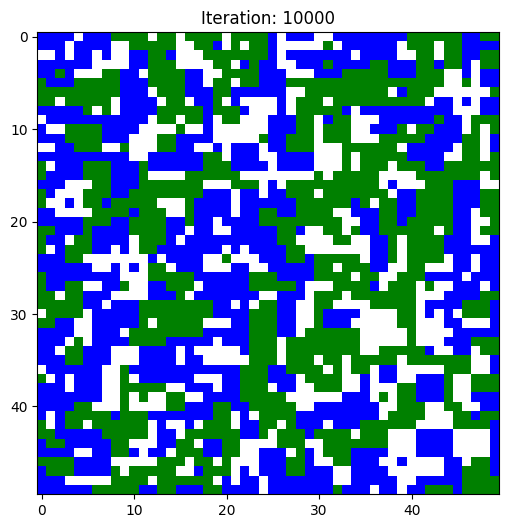

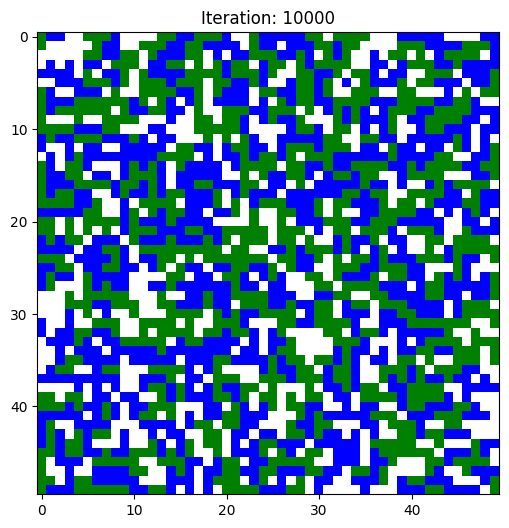

(1, None, None)

In [305]:
runSchellingSimulation(grid_size=50, density=0.75, tolerance=0.26, plot=False)
runSchellingSimulation(grid_size=50, density=0.75, tolerance=0.25, plot=False)

Symulacja dla zapełnienia 85%, z analiz wynika że Tc = 26%
Pierwsza seria rysunków dla Tolerancji krytycznej, druga obrazująca brak segregacji

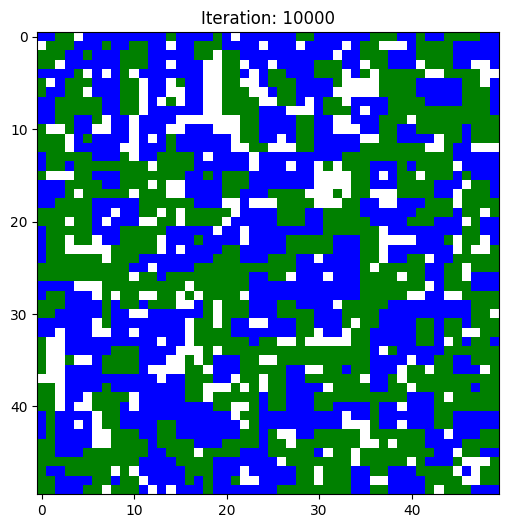

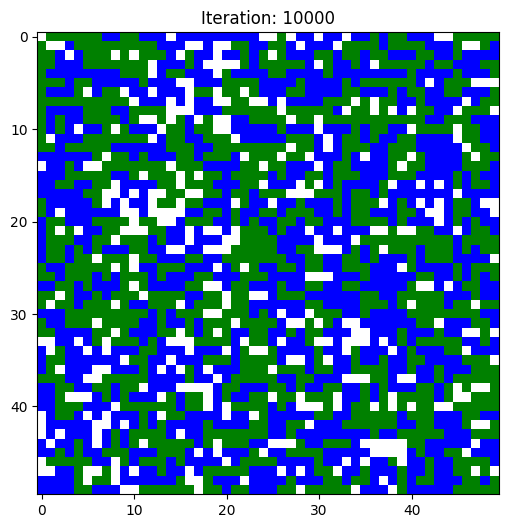

(1, None, None)

In [306]:
runSchellingSimulation(grid_size=50, density=0.85, tolerance=0.26, plot=False)
runSchellingSimulation(grid_size=50, density=0.85, tolerance=0.25, plot=False)

Symulacja dla zapełnienia 95%, z analiz wynika że Tc = 26%
Pierwsza seria rysunków dla Tolerancji krytycznej, druga obrazująca brak segregacji

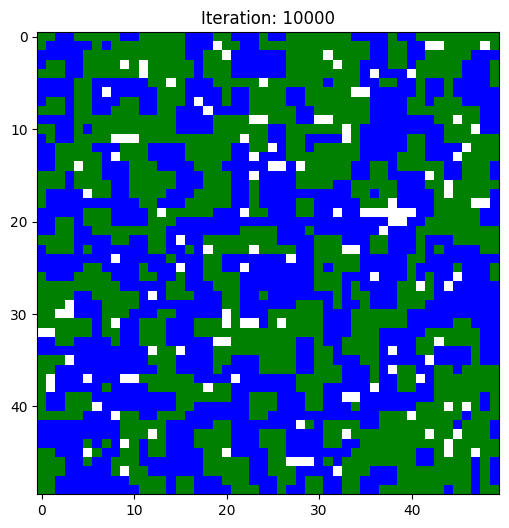

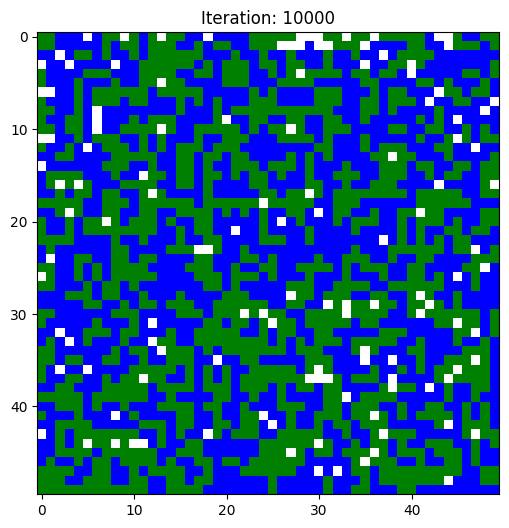

(1, None, None)

In [307]:
runSchellingSimulation(grid_size=50, density=0.95, tolerance=0.26, plot=False)
runSchellingSimulation(grid_size=50, density=0.95, tolerance=0.25, plot=False)

In [265]:
def wykres_tolerancji(step):
    '''
    ta funckja oblicza czy jest segregacja na podstawie dla przedzialu tolerancji (0, 1)
    jak jest segregacja to daje 1 jak nie to -1
    zwraca segregacji dla kazdej tolerancji
    '''

    lista_tolerancji = []
    xi = []
    for i in range(1, int(1/step)): #tutaj biore for'a od 1 bo tolerancja dla 0 to jakies dziwne rzeczy wychodza, do sprawdzenia czemu tak
        check, temp1, temp2 = runSchellingSimulation(grid_size=20, density=0.75, tolerance=i*step, map=False, plot=False)
        lista_tolerancji.append(check)
        xi.append(i*step)

    return xi, lista_tolerancji

In [254]:
lista_xi = []
lista_listy_tolerancji = []

'''
Tutaj robie statystyke czy jest segregacja czy nie bo jak jestesmy blisko granicy segregacji
to czasem wychodzi ze jest czasem ze nie xd
'''

# TODO: Odpalic to na mniejszym stepie i zrobic wieksza statystyke i tak samo dla p = 0.85 i 0.75

for i in range(5):
    xiTemp, yTemp = wykres_tolerancji(0.05)
    lista_listy_tolerancji.append(yTemp)

To jest wykres kiedy wystepuje segregacja dla density=0.95. Co ciekawe to tutaj mamy jakby po obu stronach $T_{kryt}$, dla 0.3 i 0.8.

([<matplotlib.axis.XTick at 0x266f9826450>,
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.7000000000000001, 0, '0.7'),
  Text(0.8, 0, '0.8'),
  Text(0.9, 0, '0.9'),
  Text(1.0, 0, '1.0')])

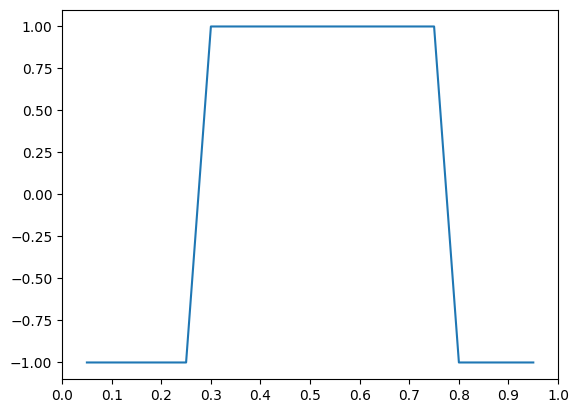

In [255]:
mean_results = np.mean(lista_listy_tolerancji, axis=0)
plt.plot(xiTemp, mean_results)
plt.xticks(np.arange(0, 1.1, step=0.1))

Tutaj jest dowód obrazkowy ze te obliczenia z pochodna maja sens i daja dobry zakres kiedy jest segregacja

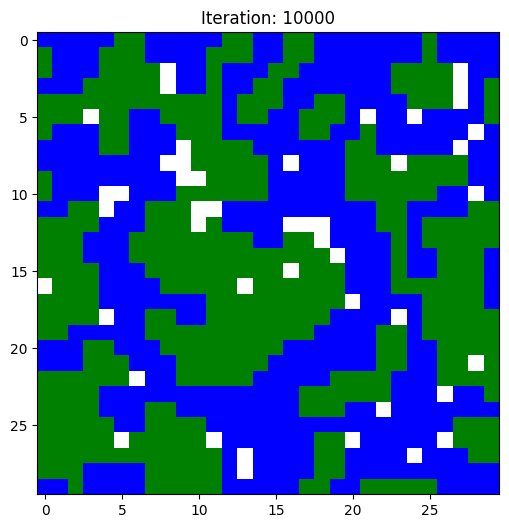

1

In [263]:
runSchellingSimulation(grid_size=30, density=0.95, tolerance=0.3, plot=False)

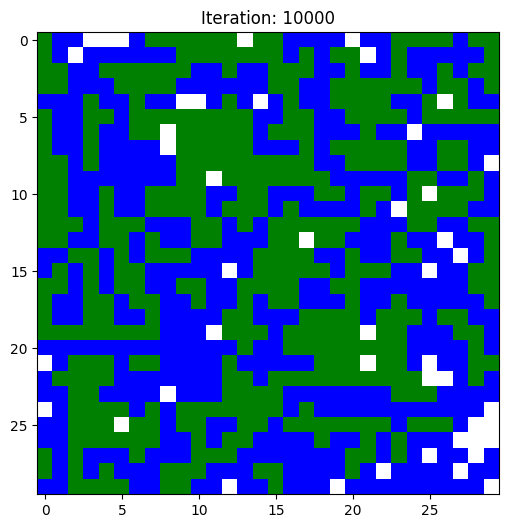

-1

In [264]:
runSchellingSimulation(grid_size=30, density=0.95, tolerance=0.2, plot=False)

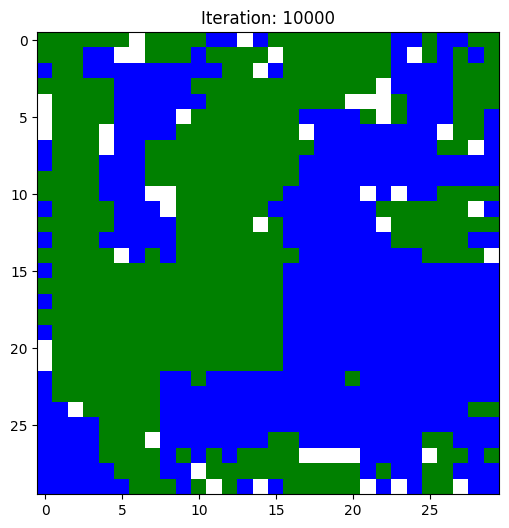

1

In [260]:
runSchellingSimulation(grid_size=30, density=0.95, tolerance=0.75, plot=False)

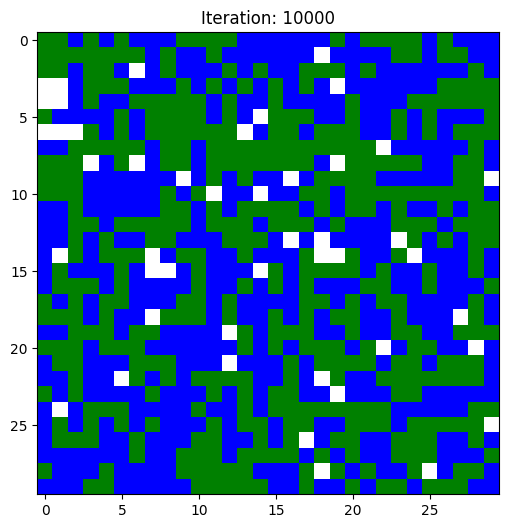

-1

In [261]:
runSchellingSimulation(grid_size=30, density=0.95, tolerance=0.8, plot=False)

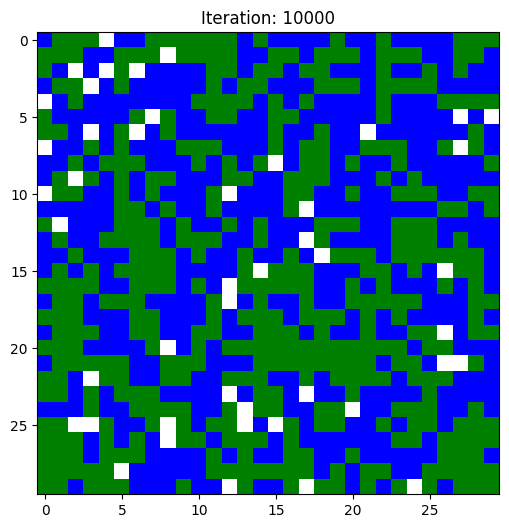

-1

In [262]:
runSchellingSimulation(grid_size=30, density=0.95, tolerance=0.9, plot=False)

Tutaj robie indetycznie co powyzej tylko dla density = 0.85.

In [241]:
lista_xi85 = []
lista_listy_tolerancji85 = []

for i in range(10): #TO
    xiTemp85, yTemp85 = wykres_tolerancji(0.05)
    lista_listy_tolerancji85.append(yTemp85)

([<matplotlib.axis.XTick at 0x266ed249760>,
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.7000000000000001, 0, '0.7'),
  Text(0.8, 0, '0.8'),
  Text(0.9, 0, '0.9'),
  Text(1.0, 0, '1.0')])

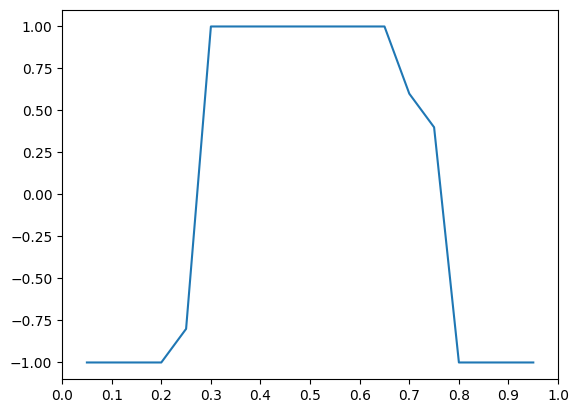

In [242]:
mean_results85 = np.mean(lista_listy_tolerancji85, axis=0)
plt.plot(xiTemp85, mean_results85)
plt.xticks(np.arange(0, 1.1, step=0.1))

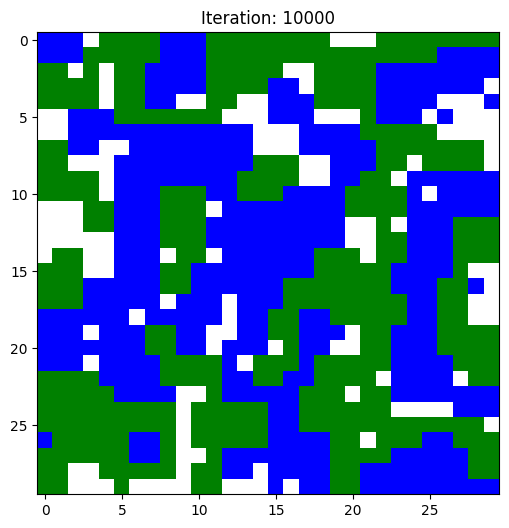

1

In [249]:
runSchellingSimulation(grid_size=30, density=0.85, tolerance=0.5, plot=False)

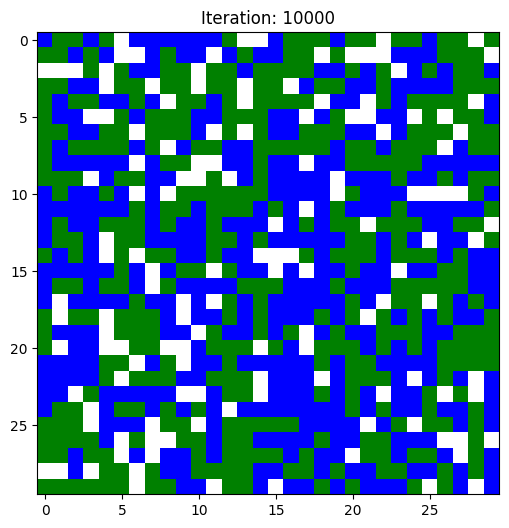

-1

In [250]:
runSchellingSimulation(grid_size=30, density=0.85, tolerance=0.8, plot=False)

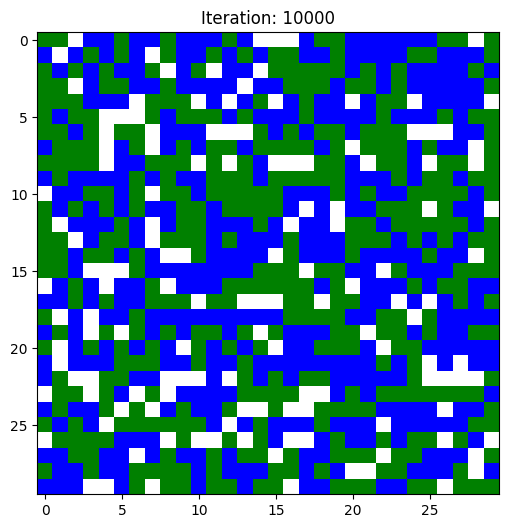

-1

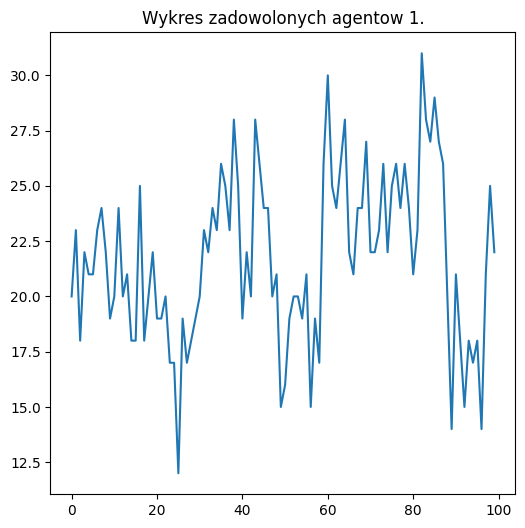

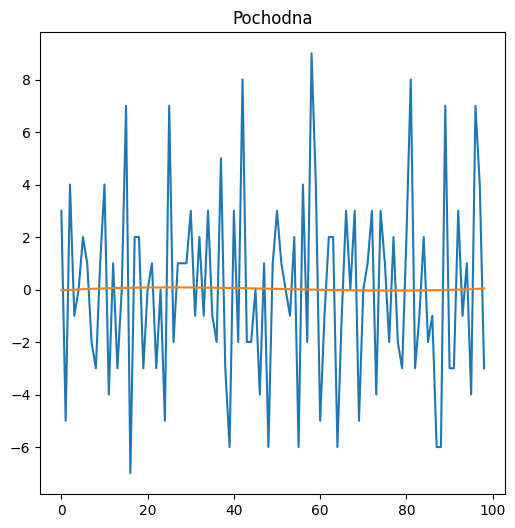

In [248]:
runSchellingSimulation(grid_size=30, density=0.85, tolerance=0.9)

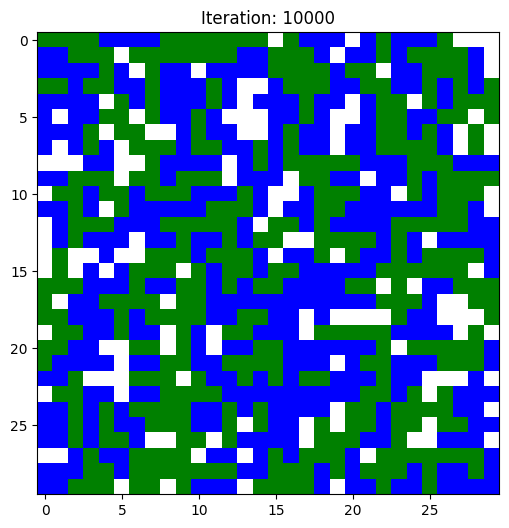

-1

In [252]:
runSchellingSimulation(grid_size=30, density=0.85, tolerance=0.1, plot=False)

Tutaj to samo tylko density = 0.75

In [268]:
lista_xi75 = []
lista_listy_tolerancji75 = []

for i in range(15):
    xiTemp75, yTemp75 = wykres_tolerancji(0.05)
    lista_listy_tolerancji75.append(yTemp75)

([<matplotlib.axis.XTick at 0x266f9077b90>,
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.7000000000000001, 0, '0.7'),
  Text(0.8, 0, '0.8'),
  Text(0.9, 0, '0.9'),
  Text(1.0, 0, '1.0')])

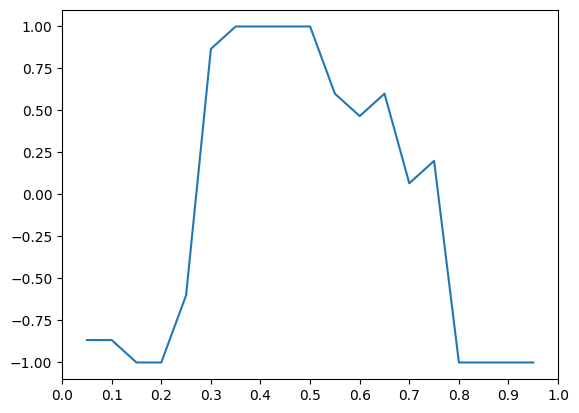

In [269]:
mean_results75 = np.mean(lista_listy_tolerancji75, axis=0)
plt.plot(xiTemp75, mean_results75)
plt.xticks(np.arange(0, 1.1, step=0.1))

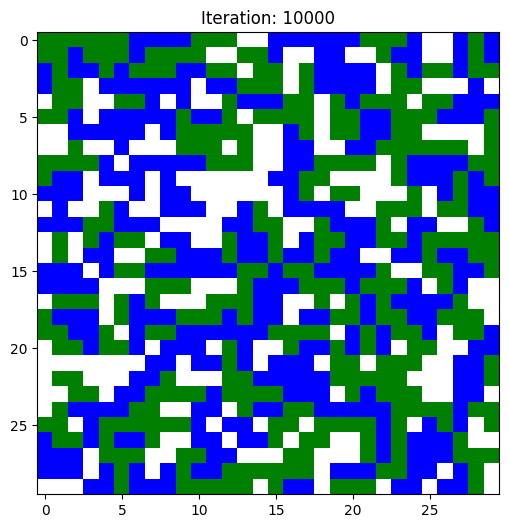

1

In [270]:
runSchellingSimulation(grid_size=30, density=0.75, tolerance=0.25, plot=False)

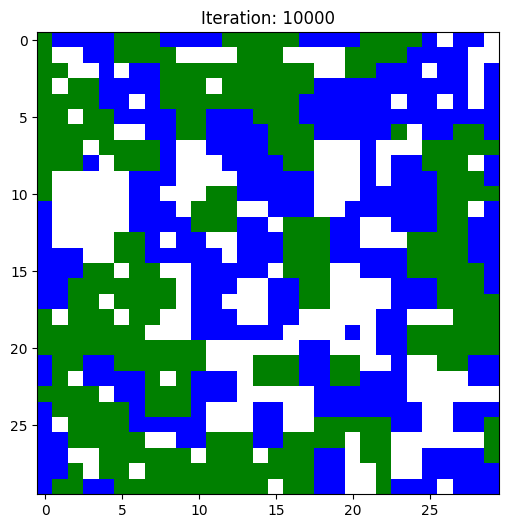

1

In [271]:
runSchellingSimulation(grid_size=30, density=0.75, tolerance=0.3, plot=False)

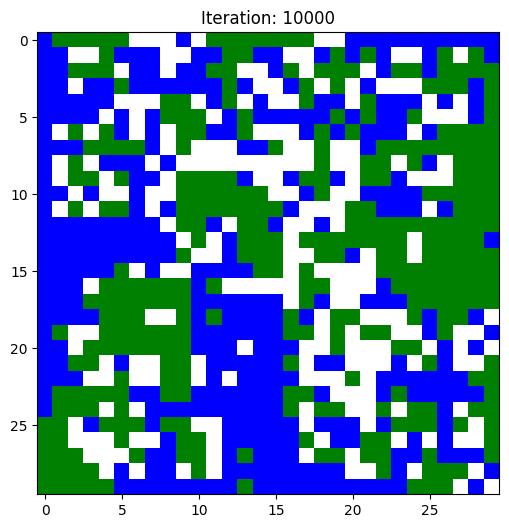

1

In [272]:
runSchellingSimulation(grid_size=30, density=0.75, tolerance=0.55, plot=False)

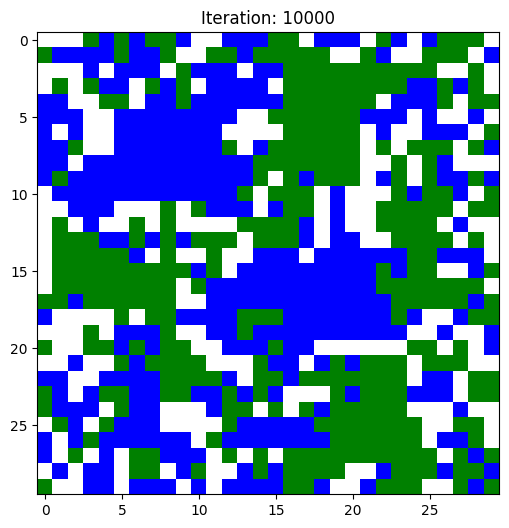

1

In [273]:
runSchellingSimulation(grid_size=30, density=0.75, tolerance=0.7, plot=False)

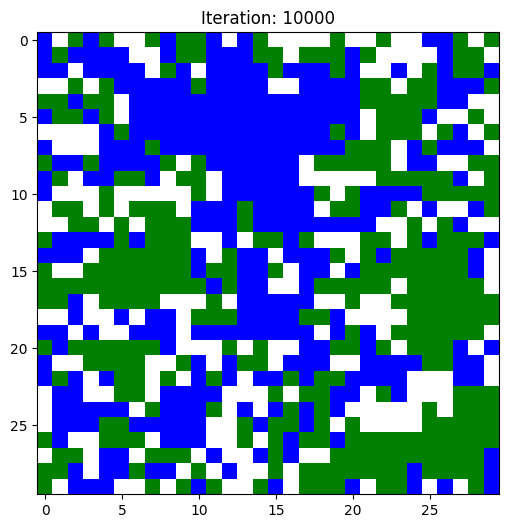

1

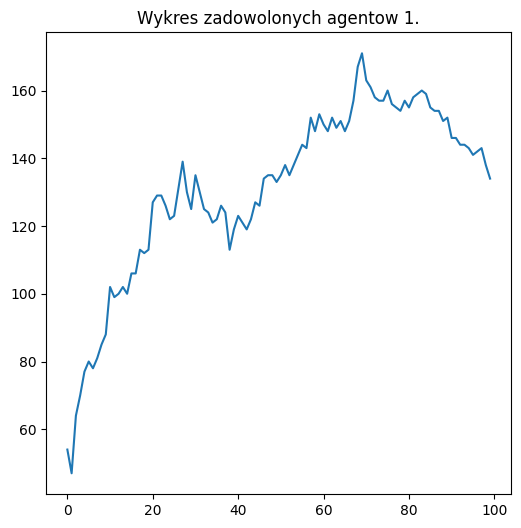

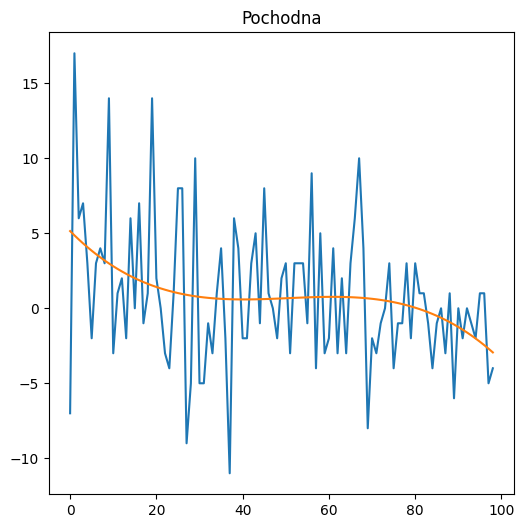

In [275]:
runSchellingSimulation(grid_size=30, density=0.75, tolerance=0.75)

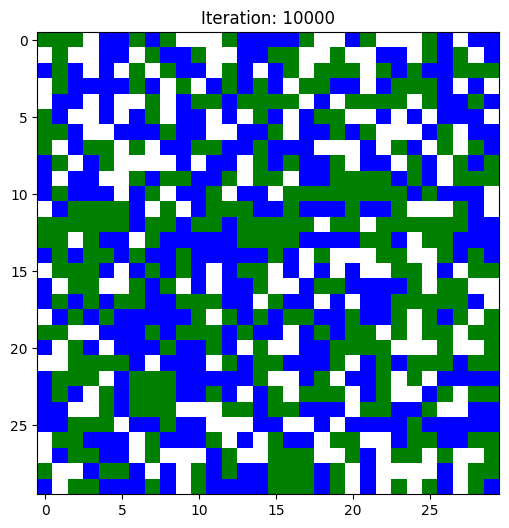

-1

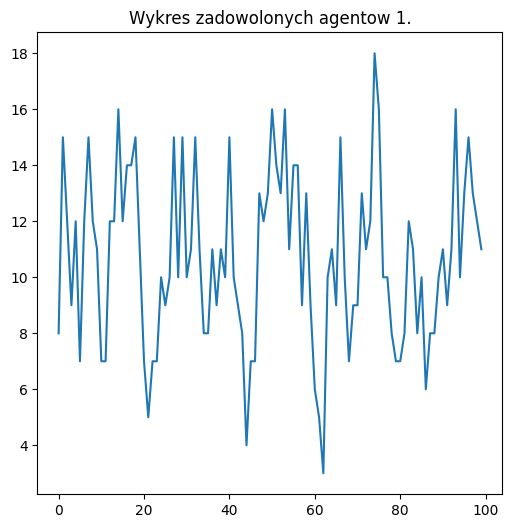

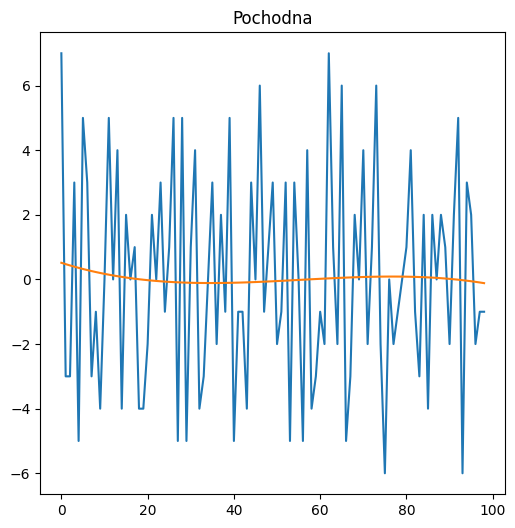

In [276]:
runSchellingSimulation(grid_size=30, density=0.75, tolerance=0.8)

In [278]:
lista_xi55 = []
lista_listy_tolerancji55 = []

for i in range(10):
    xiTemp55, yTemp55 = wykres_tolerancji(0.05)
    lista_listy_tolerancji55.append(yTemp55)

([<matplotlib.axis.XTick at 0x266f91b9760>,
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.7000000000000001, 0, '0.7'),
  Text(0.8, 0, '0.8'),
  Text(0.9, 0, '0.9'),
  Text(1.0, 0, '1.0')])

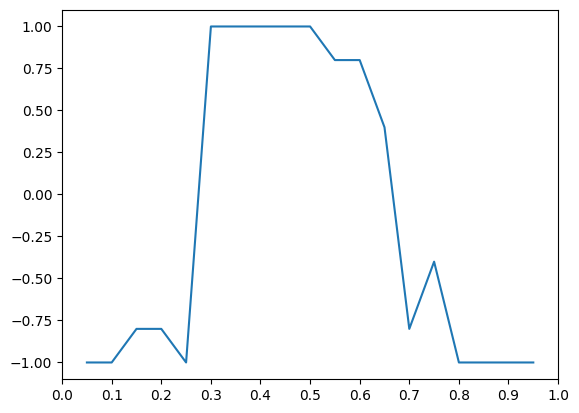

In [279]:
mean_results55 = np.mean(lista_listy_tolerancji55, axis=0)
plt.plot(xiTemp55, mean_results55)
plt.xticks(np.arange(0, 1.1, step=0.1))

Tutaj zadanie 3. wykres zadowolonych i niezadowolonych od tolerancji

In [301]:
x_satif = []

y_satif = []

x_unsatif = []

y_unsatif = []

for i in range(1, int(1/0.1)):
    srY_satif = []
    x_satif.append(i*0.1)
    srY_unsatif = []
    x_unsatif.append(i*0.1)
    print(i)
    print(i*0.1)
    for j in range(5):
        a, unsatif, satif = runSchellingSimulation(grid_size=30, density=0.1 * i, tolerance=0.8, plot=False, map=False)
        srY_satif.append(satif)
        srY_unsatif.append(unsatif)
    y_satif.append(np.mean(srY_satif))
    y_unsatif.append(np.mean(srY_unsatif))


1
0.1
2
0.2
3
0.30000000000000004
4
0.4
5
0.5
6
0.6000000000000001
7
0.7000000000000001
8
0.8
9
0.9


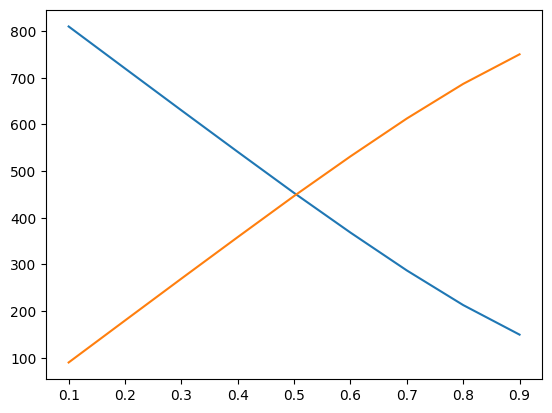

In [302]:
plt.plot(x_satif, y_satif)
plt.plot(x_unsatif, y_unsatif)